## Full Modeling Cycle for 1 CNN
1. Libraries
2. Getting Data
3. Remove Duplicates in df
4. Class DataSet
5. Image Transforms
6. Losses
7. Train Model
8. Evaluation: Confusion Matrix
9. Evaluation: Hardest images for predict

In [141]:
# ====================================================
# Libraries
# ====================================================
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import itertools
from tqdm.auto import tqdm
from functools import partial

from PIL import Image

import cv2
from skimage import io
import torch
from torch import nn
import os
import tqdm
from datetime import datetime
import time
import random
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
import timm
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

import sklearn
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import pydicom

from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()   # interactive mode


IMAGE_DIR = image_dir = '/home/arti/DL/Houses_Model_quality_of_repair/Data/Labeled/'
OUTPUT_DIR = '/home/arti/DL/Houses_Model_quality_of_repair/OUTPUTS/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # cuda:0
print(device)

cuda:0


In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    num_workers=4
    model_name='resnext50_32x4d'  # 'resnext50_32x4d'
    size=256 ###
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    T_0=10 # CosineAnnealingWarmRestarts
    epochs=10
    lr=1e-4
    min_lr=1e-6
    batch_size=16 # 32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=4
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
    print_freq=100
    smoothing=0.05

# Get Data

In [147]:
# check filenames in dir
# for filename in os.listdir(image_dir):
#     print(filename)

classes = ['good_flat', 'granny_flat', 'empty_flat', 'empty_flat_good']
img_names_df = []

for cls in classes:
    path_to_img = image_dir+cls
    for filename in os.listdir(path_to_img):
            img_names_df.append([cls+'/'+filename, cls])

img_names_df = pd.DataFrame(img_names_df)
img_names_df.columns = ['names', 'class']

img_names_df['label'] = img_names_df['class'].copy()
img_names_df.loc[(img_names_df['class'] == 'good_flat'), 'label'] = 0
img_names_df.loc[(img_names_df['class'] == 'granny_flat'), 'label'] = 1
img_names_df.loc[(img_names_df['class'] == 'empty_flat'), 'label'] = 2
img_names_df.loc[(img_names_df['class'] == 'empty_flat_good'), 'label'] = 3

print('\nDataset:')
print('len -', len(img_names_df))
print('\nsample:\n',img_names_df.sample(5))
print('\nValue counts:\n', img_names_df['label'].value_counts(), sep='')


Dataset:
len - 1309

sample:
                    names        class label
257    good_flat/494.jpg    good_flat     0
863   granny_flat/15.jpg  granny_flat     1
1151  empty_flat/631.jpg   empty_flat     2
466    good_flat/136.jpg    good_flat     0
25     good_flat/156.jpg    good_flat     0

Value counts:
0    780
1    265
2    175
3     89
Name: label, dtype: int64


# Delete duplicate images

In [4]:
def delete_duplicates():
    hashSize = 8
    hashes = {}

    for name in img_names_df['names']:
    
        image_path = IMAGE_DIR + name 
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        resized = cv2.resize(gray, (hashSize + 1, hashSize))
        # compute the (relative) horizontal gradient between adjacent column pixels
        diff = resized[:, 1:] > resized[:, :-1]
        # convert the difference image to a hash and return it
        h = sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

        # grab all image paths with that hash, add the current image
        # path to it, and store the list back in the hashes dictionary
        p = hashes.get(h, [])
        p.append(name)
        hashes[h] = p

    duplicates = []
    for value in hashes.values():
        if(len(value) > 1):
            duplicates.append(value[1:])

    duplicates = np.array(duplicates).flatten()
    print(duplicates)

    for dplt in duplicates:
        os.remove(IMAGE_DIR + dplt)
        print(dplt, 'removed')
        
    pass
        
#delete_duplicates()

# 3

In [5]:
train, test = train_test_split(img_names_df, test_size=0.2, shuffle=True, random_state=42)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
print('\nTrain and Val shapes: ',train.shape, test.shape)


Train and Val shapes:  (1047, 3) (262, 3)


train.to_csv(OUTPUT_DIR+'train.csv',index=False)
test.to_csv(OUTPUT_DIR+'test.csv',index=False)

#range(x) = * 2 pover of x
for i in range(2):
    train = pd.concat([train, train[train.label==3]], axis=0)
for i in range(1):
    train = pd.concat([train, train[train.label==1]], axis=0)
train = train.reset_index(drop=True)

# Class Dataset

In [6]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['names'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = image_dir + file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()  # self.labels[idx]
        return image, label, file_name
    
    
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['names'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):    
        file_name = self.file_names[idx]
        file_path = image_dir + file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

# Transforms

In [7]:
# ====================================================
# Transforms
# https://albumentations.ai/docs/api_reference/augmentations/transforms/
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([            
            Rotate(limit=10, p=0.7),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.75, 1)),
            HorizontalFlip(p=0.5),
            
            OneOf([
                A.Cutout(max_h_size=15,max_w_size=15),  
                A.CoarseDropout(max_height=25, max_width=25, min_height=10, min_width=10, fill_value=0)], p=0.5), 
                                                             
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'train_without_augment':
        return Compose([            
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.8, 1)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# Criterion
Notebook with criterions: https://www.kaggle.com/piantic/train-cassava-starter-using-various-loss-funcs/notebook

In [8]:
# ====================================================
# CrossEntropyLoss
# ====================================================
nn.CrossEntropyLoss()  
nn.BCELoss()

# ====================================================
# Label Smoothing
# ====================================================
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes=5, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad():
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
# ====================================================
# TaylorCrossEntropyLoss
# ==================================================== 
class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class TaylorCrossEntropyLoss(nn.Module):
    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.05):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG.target_size, smoothing=smoothing)

    def forward(self, logits, labels):
        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

# Class Model (CustomResNext)

In [9]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False, w_freeze=False):
        super().__init__()
        self.model = models.resnext50_32x4d(pretrained=pretrained)
        #self.model = timm.create_model(model_name, pretrained=pretrained)
        
        if w_freeze:
            for param in self.model.parameters():
                param.requires_grad = False
        
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

## Helper functions

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def seed_torch(seed=500):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

# ====================================================
# Helper functions
# ====================================================

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

# Train

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):    
    # switch to train mode
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)

        t_outputs = model(images) # every batch of 100 images are put as an input.
        t_loss = criterion(t_outputs, labels)

        optimizer.zero_grad() #setting the initial gradient to 0
        t_loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        preds = torch.max(t_outputs, 1)[1] # taking the highest value of prediction.

        running_loss += t_loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
    
    # Total Epoch loss and Acc
    epoch_loss = running_loss/len(train_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(train_loader) # accuracy per epoch
        
    return epoch_loss, epoch_acc

def valid_fn(val_loader, model, criterion, device):    
    # switch to evaluation mode
    model.eval()
    
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    with torch.no_grad(): # we do not need gradient for validation.

        for v_images, v_labels, _ in val_loader:
            v_images, v_labels = v_images.to(device), v_labels.to(device)

            val_outputs = model(v_images)
            val_loss = criterion(val_outputs, v_labels)
            
            val_preds = torch.max(val_outputs, 1)[1]
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == v_labels.data)
            
        val_epoch_loss = val_running_loss/len(val_loader)
        val_epoch_acc = val_running_corrects.float()/ len(val_loader)
    
    return val_epoch_loss, val_epoch_acc

def train_loop(train_loader, val_loader, model, criterion, optimizer, epochs, device):
    model.to(device);
    
    for epoch in range(epochs):
        print('epoch :', epoch)
        
        epoch_loss, epoch_acc = train_fn(train_loader, model, criterion, optimizer, device)
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()/CFG.batch_size))
        
        val_epoch_loss, val_epoch_acc = valid_fn(val_loader, model, criterion, device)
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()/CFG.batch_size))

In [32]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))  # train train_without_augment
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

val_dataset = TrainDataset(test, transform=get_transforms(data='valid'))
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

print('Train:', len(train_dataset), len(train_loader))
print('Test: ', len(val_dataset), len(val_loader))

Train: 1047 65
Test:  262 16


In [33]:
model = CustomResNext(CFG.model_name, pretrained=True)
#model.load_state_dict(torch.load('/home/arti/DL/Houses_Model_quality_of_repair/model_base.pth'))
model.to(device);

for param in model.model.parameters():
    param.requires_grad = True

optimizer = Adam(model.parameters(), lr=CFG.lr/10, weight_decay=CFG.weight_decay, amsgrad=False)
error = LabelSmoothingLoss(classes=CFG.target_size, smoothing=0.07) # nn.BCELoss()

lr 
10 epochs
0.8640  - 0.87

lr/10
5 epochs
0.86 - 0.885

lr/100
5 epochs
0.87 - 0.90

In [42]:
# Change lr without changing optim values (like accumulated momentum)
optimizer.param_groups[0]['lr'] = 1e-5

train_loop(train_loader, val_loader, model, error, optimizer, 1, device)

epoch : 0
training loss: 0.6555, acc 0.8510 
validation loss: 0.6051, validation acc 0.8789 


In [52]:
# ====================================================
# Fit model to save
# ====================================================
#train_dataset = TrainDataset(img_names_df, transform=get_transforms(data='train'))  # train train_without_augment
#train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
#                          num_workers=4, pin_memory=True, drop_last=True)
#val_dataset = TrainDataset(img_names_df[:100], transform=get_transforms(data='valid'))
#val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=True,
#                          num_workers=4, pin_memory=True, drop_last=True)

# train_loop(train_loader, val_loader, model, error, optimizer, 10, device)
# torch.save(model.state_dict(), OUTPUT_DIR+'models/model_0_8945.pth')

# Confusion matrix

In [139]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.float() / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

@torch.no_grad()
def get_all_preds(model, loader):
    model.eval()
    all_preds = []
    
    for images, labels,_ in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.max(outputs, 1)[1]
        all_preds.append([labels.item(), preds.item()])
        
    return torch.tensor(all_preds)

def create_matrix(tl_pl, n_cls):
    cmt = torch.zeros(n_cls,n_cls, dtype=torch.int64)
    for p in tl_pl:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    return cmt

Normalized confusion matrix
tensor([[0.9241, 0.0570, 0.0190, 0.0000],
        [0.2549, 0.6471, 0.0980, 0.0000],
        [0.0000, 0.0000, 0.9688, 0.0312],
        [0.2381, 0.0000, 0.4286, 0.3333]])


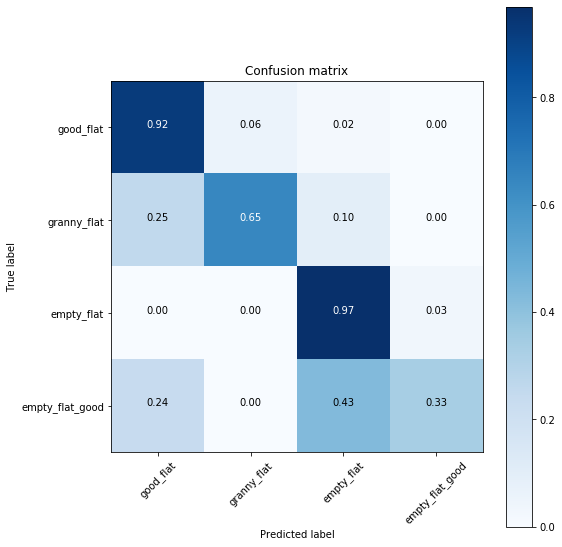

In [148]:
loader = DataLoader(val_dataset, batch_size=1, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)
all_preds = get_all_preds(model, loader)

cmt = create_matrix(all_preds, n_cls=4)

# plot matrix
plt.figure(figsize=(8,8))
classes = ['good_flat', 'granny_flat', 'empty_flat', 'empty_flat_good']
plot_confusion_matrix(cmt, classes, normalize=True)

# Hardest images for Model

True label: good_flat 
Predicted label:  granny_flat 
Image:  ['good_flat/591.jpg']


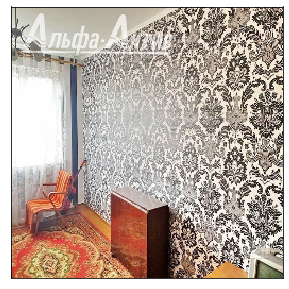

True label: good_flat 
Predicted label:  granny_flat 
Image:  ['good_flat/727.jpg']


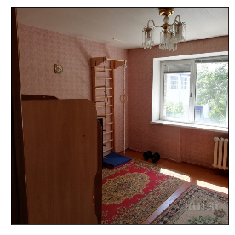

True label: good_flat 
Predicted label:  empty_flat 
Image:  ['good_flat/687.jpg']


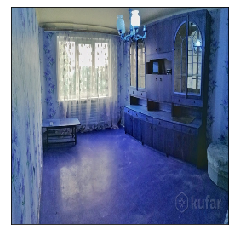

In [153]:
def image_loss_mapping(model, loader, names, criterion, device):
    model.to(device);
    model.eval();
    
    img_loss_mapping = {}

    with torch.no_grad():
        for i, (inputs, classes, file_name) in enumerate(val_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, classes)
            preds = torch.max(outputs, 1)[1]
            
            img_loss_mapping[loss.item()] = [inputs, names[classes.item()], names[preds.item()], file_name]
    
    return img_loss_mapping
        
def plot_k_hardest_images(mapping, k, names):
    plt.figure(figsize=(16, 5))
    UnNormalize = transforms.Compose([ 
        transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),])
    
    hardest_k = sorted(list(img_loss_mapping))[-k:]
    
    for k in hardest_k:
        image = mapping[k][0].cpu()[0]
        image = UnNormalize(image)
        image = image.numpy()
        image = np.moveaxis(image, 0, -1)
        print('True label:', mapping[k][1], '\nPredicted label: ', mapping[k][2], '\nImage: ', mapping[k][3])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
        plt.show()

# Plotting hardest images and their names
names = ['good_flat', 'granny_flat', 'empty_flat', 'empty_flat_good']
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
img_loss_mapping = image_loss_mapping(model, val_loader, names, error, device)
plot_k_hardest_images(img_loss_mapping, 3, names)

# Visualizing Neural Network Layer Activation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
(256, 256, 3)


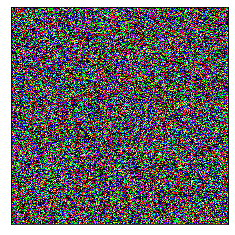

In [69]:
plt.show()

In [ ]:
# ====================================================
# Old Training -- working
# ====================================================
if 0:
    model.train()

    epochs = 3
    running_loss_history = []
    running_corrects_history = []
    val_running_loss_history = []
    val_running_corrects_history = []

    for epoch in range(epochs):

        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0

        for images, labels, _ in train_loader:

            images, labels = images.to(device), labels.to(device)


            t_outputs = model(images) # every batch of 100 images are put as an input.
            t_loss = error(t_outputs, labels)




            optimizer.zero_grad() #setting the initial gradient to 0
            t_loss.backward() # backpropagating the loss
            optimizer.step() # updating the weights and bias values for every single step.

            preds = torch.max(t_outputs, 1)[1] # taking the highest value of prediction.


            running_loss += t_loss.item()
            running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.


        # Epoch Validation
        else:
            with torch.no_grad(): # we do not need gradient for validation.

                for v_images, v_labels, _ in val_loader:
                    v_images, v_labels = v_images.to(device), v_labels.to(device)

                    val_outputs = model(v_images)
                    val_loss = error(val_outputs, v_labels)
                    #print('=>', val_outputs, v_labels)

                    val_preds = torch.max(val_outputs, 1)[1]
                    val_running_loss += val_loss.item()
                    val_running_corrects += torch.sum(val_preds == v_labels.data)
                    #print('<=', val_preds, v_labels.data)

        # Total Epoch loss and Acc
        epoch_loss = running_loss/len(train_loader) # loss per epoch
        epoch_acc = running_corrects.float()/ len(train_loader) # accuracy per epoch
        # print(4, running_corrects.float(), len(train_loader))
        running_loss_history.append(epoch_loss) # appending for displaying 
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(val_loader)
        val_epoch_acc = val_running_corrects.float()/ len(val_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('epoch :', epoch)
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()/CFG.batch_size))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()/CFG.batch_size))